In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.residual_attention import ResidualAttentionNetwork
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

In [3]:
artifact_path = Path("../../artifacts/residual-attention-network")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = ResidualAttentionNetwork(output_size=num_class, num_layer=56).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                      Param #
ResidualAttentionNetwork                                                    --
├─Sequential: 1-1                                                           --
│    └─Conv2dNormActivation: 2-1                                            --
│    │    └─Conv2d: 3-1                                                     9,472
│    │    └─ReLU: 3-2                                                       --
│    └─MaxPool2d: 2-2                                                       --
│    └─BatchNorm2d: 2-3                                                     128
│    └─ReLU: 2-4                                                            --
├─Sequential: 1-2                                                           --
│    └─AttentionModule: 2-5                                                 --
│    │    └─Sequential: 3-3                                                 74,624
│    │    └─Sequential: 3-4            

# training

In [11]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [14]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 3272/3272 [31:19<00:00,  1.74it/s]


epoch 1 : 0.02966595292637867


100%|██████████| 3272/3272 [20:32<00:00,  2.66it/s]


epoch 2 : 0.024424849684898966


100%|██████████| 3272/3272 [20:10<00:00,  2.70it/s]


epoch 3 : 0.021751269092726407


100%|██████████| 3272/3272 [20:26<00:00,  2.67it/s]


epoch 4 : 0.019763440522123334


100%|██████████| 3272/3272 [20:27<00:00,  2.66it/s]


epoch 5 : 0.018151958140574194


100%|██████████| 3272/3272 [20:11<00:00,  2.70it/s]


epoch 6 : 0.016806680654046925


100%|██████████| 3272/3272 [20:15<00:00,  2.69it/s]


epoch 7 : 0.015621627540276944


100%|██████████| 3272/3272 [20:09<00:00,  2.71it/s]


epoch 8 : 0.014645111590679645


100%|██████████| 3272/3272 [20:42<00:00,  2.63it/s]


epoch 9 : 0.013563649799056525


100%|██████████| 3272/3272 [21:19<00:00,  2.56it/s]

epoch 10 : 0.012730562554650729


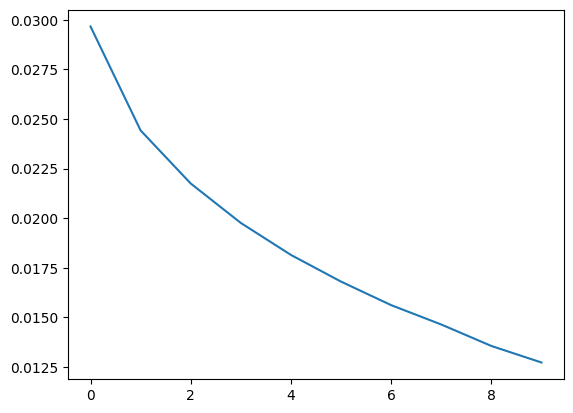

In [15]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [20]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 3273/3273 [08:51<00:00,  6.16it/s]

[[3621  182    5  107   18  119  201  155  394   61]
 [ 174 1708    9   43    8    1  453   65  155    7]
 [  78  148  892   10    5    6  108   66   85   48]
 [   9    2    3 1809    2    0    5    3  273    6]
 [ 148   16   10  170 2310   14   27   49  254  100]
 [ 221    0    6  106    9  925    9   22  304   66]
 [ 110   75    9    9    0    0 1395  185   78    5]
 [ 116   25   25   12   13    6  302 1124  152   45]
 [  19    1    6  137    2    4    4    3 4634   11]
 [  98    2    5   84    3   57    3   12  406 1192]]


In [24]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.744602097470697
cavallo   : 0.6511627906976745
elefante  : 0.6168741355463347
farfalla  : 0.8565340909090909
gallina   : 0.7456423499031634
gatto     : 0.5545563549160671
mucca     : 0.747588424437299
pecora    : 0.6175824175824176
ragno     : 0.9612113669363203
scoiattolo: 0.640171858216971


In [25]:
per_class_acc.mean()

0.7135925886616035

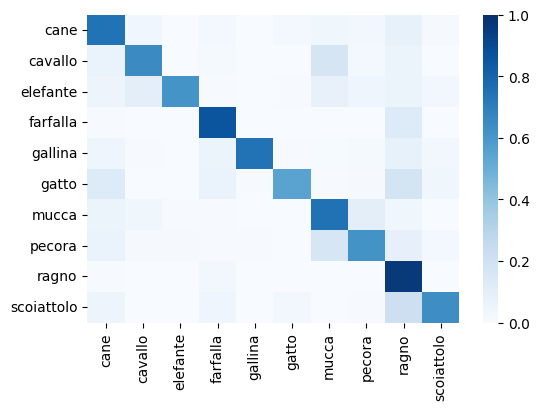

In [26]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [16]:
model_path = artifact_path / 'attention-net-56.pth'

In [17]:
torch.save(model.state_dict(), model_path)

In [18]:
get_file_size(model_path)

'190.65MB'

In [27]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>